Isotropic Total Variation (Accelerated PGM)
===========================================

This example demonstrates the use of class [pgm.AcceleratedPGM](../_autosummary/scico.pgm.rst#scico.pgm.AcceleratedPGM) to solve isotropic total variation (TV) regularization.
It solves the denosing problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x} \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient vectors at each point in the image $\mathbf{x}$.
The same reconstruction is performed with anisotropic TV regularization for comparison;
the isotropic version shows fewer block-like artifacts.

The solution via PGM is based on <cite data-cite="beck-2009-tv"/>. This follows a dual approach that constructs a dual for the constrained denoising problem (the constraint given by restricting the solution to the [0,1] range). The PGM solution minimizes the resulting dual. In this case, switching between the two regularizers corresponds to switching between two different projectors.

In [1]:
from typing import Callable, Optional, Union

import jax
import jax.numpy as jnp
import jax.scipy as jsp

from scico import functional, linop, loss, operator, plot
from scico.blockarray import BlockArray
from scico.pgm import AcceleratedPGM, RobustLineSearchStepSize
from scico.typing import JaxArray
from scico.util import ensure_on_device
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # Image size

# these steps create a ground truth image by spatially filtering noise
kernel_size = N // 5
key = jax.random.PRNGKey(1)
x_gt = jax.random.uniform(key, shape=(N + kernel_size - 1, N + kernel_size - 1))
x = jnp.linspace(-3, 3, kernel_size)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
window = window / window.sum()
x_gt = jsp.signal.convolve(x_gt, window, mode="valid")
x_gt = (x_gt > jnp.percentile(x_gt, 25)).astype(float) + (x_gt > jnp.percentile(x_gt, 75)).astype(
    float
)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
sigma = 1.0  # noise standard deviation
key, subkey = jax.random.split(key)

n = sigma * jax.random.normal(subkey, shape=x_gt.shape)

y = x_gt + n

Define finite difference operator and adjoint

In [4]:
# the append=0 option appends 0 to the input along the axis
# prior to performing the difference to make the results of
# horizontal and vertical finite differences the same shape
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
A = C.adj

Define initial estimation: a zero array

In [5]:
x0 = jnp.zeros(C(y).shape)

Define the dual of the total variation denoising problem

In [6]:
class DualTVLoss(loss.Loss):
    def __init__(
        self,
        y: Union[JaxArray, BlockArray],
        A: Optional[Union[Callable, operator.Operator]] = None,
        lmbda: float = 0.5,
    ):
        y = ensure_on_device(y)
        self.functional = functional.SquaredL2Norm()
        super().__init__(y=y, A=A, scale=1.0)
        self.lmbda = lmbda

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:

        xint = self.y - self.lmbda * self.A(x)
        return -1.0 * self.functional(xint - jnp.clip(xint, 0.0, 1.0)) + self.functional(xint)

Denoise with isotropic total variation.
Define projector for isotropic total variation.

In [7]:
# Evaluation of functional set to zero
class IsoProjector(functional.Functional):

    has_eval = True
    has_prox = True
    is_smooth = False

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, x: JaxArray, lam: float) -> JaxArray:
        norm_x_ptp = jnp.sqrt(jnp.sum(jnp.abs(x) ** 2, axis=0))

        x_out = x / jnp.maximum(jnp.ones(x.shape), norm_x_ptp)
        out1 = x[0, :, -1] / jnp.maximum(jnp.ones(x[0, :, -1].shape), jnp.abs(x[0, :, -1]))
        x_out_1 = jax.ops.index_update(x_out, jax.ops.index[0, :, -1], out1)
        out2 = x[1, -1, :] / jnp.maximum(jnp.ones(x[1, -1, :].shape), jnp.abs(x[1, -1, :]))
        x_out = jax.ops.index_update(x_out_1, jax.ops.index[1, -1, :], out2)

        return x_out

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver object. Run the solver.

In [8]:
reg_weight_iso = 2e0
f_iso = DualTVLoss(y=y, A=A, lmbda=reg_weight_iso)
f_iso.is_smooth = True
g_iso = IsoProjector()

solver_iso = AcceleratedPGM(
    f=f_iso,
    g=g_iso,
    L0=16.0 * f_iso.lmbda ** 2,
    x0=x0,
    maxiter=100,
    verbose=True,
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
x = solver_iso.solve()
hist_iso = solver_iso.itstat_object.history(transpose=True)
# project to constraint set
x_iso = jnp.clip(y - f_iso.lmbda * f_iso.A(x), 0.0, 1.0)

Iter  Objective  L         Residual
-----------------------------------
   0  4.629e+04  5.760e+01  1.477e+01
   1  3.869e+04  5.184e+01  1.302e+01
   2  3.295e+04  4.666e+01  1.331e+01
   3  2.931e+04  4.199e+01  1.215e+01
   4  2.716e+04  3.779e+01  1.059e+01
   5  2.584e+04  3.401e+01  9.448e+00
   6  2.520e+04  6.122e+01  5.786e+00


   7  2.469e+04  5.510e+01  5.623e+00
   8  2.426e+04  4.959e+01  5.578e+00
   9  2.389e+04  4.463e+01  5.594e+00
  10  2.355e+04  4.017e+01  5.677e+00
  11  2.324e+04  3.615e+01  5.825e+00
  12  2.295e+04  3.254e+01  6.055e+00
  13  2.275e+04  5.856e+01  4.291e+00
  14  2.256e+04  5.271e+01  4.517e+00


  15  2.236e+04  4.744e+01  4.795e+00
  16  2.217e+04  4.269e+01  5.085e+00
  17  2.197e+04  3.842e+01  5.399e+00
  18  2.177e+04  3.458e+01  5.747e+00
  19  2.163e+04  6.225e+01  4.174e+00
  20  2.148e+04  5.602e+01  4.424e+00
  21  2.134e+04  5.042e+01  4.700e+00
  22  2.119e+04  4.538e+01  4.982e+00


  23  2.104e+04  4.084e+01  5.268e+00
  24  2.089e+04  3.676e+01  5.559e+00
  25  2.075e+04  3.308e+01  5.860e+00
  26  2.064e+04  5.955e+01  4.248e+00
  27  2.054e+04  5.359e+01  4.454e+00
  28  2.044e+04  4.823e+01  4.668e+00
  29  2.034e+04  4.341e+01  4.878e+00
  30  2.024e+04  3.907e+01  5.079e+00


  31  2.014e+04  3.516e+01  5.273e+00
  32  2.005e+04  3.164e+01  5.481e+00
  33  1.999e+04  5.696e+01  3.945e+00
  34  1.993e+04  5.126e+01  4.065e+00
  35  1.987e+04  4.614e+01  4.213e+00
  36  1.981e+04  4.152e+01  4.353e+00
  37  1.975e+04  3.737e+01  4.501e+00
  38  1.971e+04  6.727e+01  3.233e+00
  39  1.968e+04  6.054e+01  3.332e+00
  40  1.964e+04  5.449e+01  3.445e+00


  41  1.960e+04  4.904e+01  3.554e+00
  42  1.957e+04  4.414e+01  3.663e+00
  43  1.953e+04  3.972e+01  3.773e+00
  44  1.950e+04  3.575e+01  3.879e+00
  45  1.946e+04  3.217e+01  3.979e+00
  46  1.944e+04  5.791e+01  2.864e+00
  47  1.943e+04  5.212e+01  2.951e+00
  48  1.941e+04  4.691e+01  3.041e+00
  49  1.938e+04  4.222e+01  3.127e+00
  50  1.936e+04  3.800e+01  3.216e+00
  51  1.934e+04  3.420e+01  3.304e+00


  52  1.933e+04  6.156e+01  2.387e+00
  53  1.932e+04  5.540e+01  2.465e+00
  54  1.931e+04  4.986e+01  2.544e+00
  55  1.930e+04  4.487e+01  2.626e+00
  56  1.928e+04  4.039e+01  2.709e+00
  57  1.927e+04  3.635e+01  2.789e+00
  58  1.925e+04  3.271e+01  2.872e+00
  59  1.925e+04  5.888e+01  2.081e+00
  60  1.924e+04  5.300e+01  2.150e+00


  61  1.923e+04  4.770e+01  2.220e+00
  62  1.922e+04  4.293e+01  2.295e+00
  63  1.921e+04  3.863e+01  2.371e+00
  64  1.920e+04  3.477e+01  2.443e+00
  65  1.920e+04  6.259e+01  1.772e+00
  66  1.920e+04  5.633e+01  1.832e+00
  67  1.919e+04  5.070e+01  1.896e+00
  68  1.918e+04  4.563e+01  1.962e+00


  69  1.918e+04  4.106e+01  2.028e+00
  70  1.917e+04  3.696e+01  2.093e+00
  71  1.916e+04  3.326e+01  2.166e+00
  72  1.916e+04  5.987e+01  1.579e+00
  73  1.916e+04  5.388e+01  1.637e+00
  74  1.915e+04  4.850e+01  1.696e+00
  75  1.915e+04  4.365e+01  1.757e+00
  76  1.914e+04  3.928e+01  1.822e+00


  77  1.914e+04  3.535e+01  1.888e+00
  78  1.913e+04  6.364e+01  1.378e+00
  79  1.913e+04  5.727e+01  1.433e+00
  80  1.913e+04  5.154e+01  1.487e+00
  81  1.913e+04  4.639e+01  1.545e+00
  82  1.912e+04  4.175e+01  1.605e+00
  83  1.912e+04  3.758e+01  1.666e+00
  84  1.911e+04  3.382e+01  1.730e+00
  85  1.911e+04  3.044e+01  1.796e+00
  86  1.911e+04  5.479e+01  1.313e+00


  87  1.911e+04  4.931e+01  1.357e+00
  88  1.911e+04  4.438e+01  1.407e+00
  89  1.910e+04  3.994e+01  1.461e+00
  90  1.910e+04  7.189e+01  1.072e+00
  91  1.910e+04  6.470e+01  1.116e+00
  92  1.910e+04  5.823e+01  1.160e+00
  93  1.910e+04  5.241e+01  1.205e+00
  94  1.910e+04  4.717e+01  1.251e+00
  95  1.910e+04  4.245e+01  1.297e+00
  96  1.909e+04  3.821e+01  1.344e+00


  97  1.909e+04  3.438e+01  1.395e+00
  98  1.908e+04  3.095e+01  1.450e+00
  99  1.909e+04  5.570e+01  1.067e+00


Denoise with anisotropic total variation for comparison.
Define projector for anisotropic total variation.

In [9]:
# Evaluation of functional set to zero
class AnisoProjector(functional.Functional):

    has_eval = True
    has_prox = True
    is_smooth = False

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, x: JaxArray, lam: float) -> JaxArray:

        return x / jnp.maximum(jnp.ones(x.shape), jnp.abs(x))

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver object. Weight was tuned to give the same data fidelty as the isotropic case. Run the solver.

In [10]:
reg_weight_aniso = 1.74e0
f = DualTVLoss(y=y, A=A, lmbda=reg_weight_aniso)
f.is_smooth = True
g = AnisoProjector()

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=16.0 * f.lmbda ** 2,
    x0=x0,
    maxiter=100,
    verbose=True,
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
x = solver.solve()
# project to constraint set
x_aniso = jnp.clip(y - f.lmbda * f.A(x), 0.0, 1.0)

Iter  Objective  L         Residual
-----------------------------------
   0  4.629e+04  4.360e+01  1.697e+01
   1  3.869e+04  3.924e+01  1.497e+01
   2  3.295e+04  3.531e+01  1.530e+01
   3  2.931e+04  3.178e+01  1.396e+01
   4  2.716e+04  2.860e+01  1.218e+01
   5  2.584e+04  2.574e+01  1.086e+01
   6  2.520e+04  4.634e+01  6.649e+00
   7  2.469e+04  4.171e+01  6.460e+00


   8  2.426e+04  3.753e+01  6.408e+00
   9  2.389e+04  3.378e+01  6.420e+00
  10  2.356e+04  3.040e+01  6.510e+00
  11  2.325e+04  2.736e+01  6.680e+00
  12  2.296e+04  2.463e+01  6.930e+00
  13  2.276e+04  4.433e+01  4.908e+00
  14  2.257e+04  3.989e+01  5.163e+00
  15  2.238e+04  3.591e+01  5.476e+00
  16  2.218e+04  3.231e+01  5.809e+00


  17  2.198e+04  2.908e+01  6.161e+00
  18  2.178e+04  2.617e+01  6.556e+00
  19  2.164e+04  4.711e+01  4.757e+00
  20  2.150e+04  4.240e+01  5.037e+00
  21  2.136e+04  3.816e+01  5.343e+00
  22  2.121e+04  3.435e+01  5.659e+00
  23  2.106e+04  3.091e+01  5.979e+00
  24  2.092e+04  2.782e+01  6.309e+00
  25  2.077e+04  2.504e+01  6.646e+00
  26  2.067e+04  4.507e+01  4.813e+00


  27  2.057e+04  4.056e+01  5.044e+00
  28  2.046e+04  3.651e+01  5.285e+00
  29  2.036e+04  3.286e+01  5.526e+00
  30  2.026e+04  2.957e+01  5.769e+00
  31  2.017e+04  2.661e+01  6.009e+00
  32  2.007e+04  2.395e+01  6.262e+00
  33  2.001e+04  4.311e+01  4.510e+00
  34  1.994e+04  3.880e+01  4.650e+00
  35  1.988e+04  3.492e+01  4.824e+00
  36  1.982e+04  3.143e+01  4.997e+00
  37  1.976e+04  2.829e+01  5.176e+00


  38  1.972e+04  5.092e+01  3.718e+00
  39  1.968e+04  4.582e+01  3.836e+00
  40  1.964e+04  4.124e+01  3.968e+00
  41  1.960e+04  3.712e+01  4.096e+00
  42  1.956e+04  3.341e+01  4.217e+00
  43  1.952e+04  3.007e+01  4.336e+00
  44  1.949e+04  2.706e+01  4.454e+00
  45  1.945e+04  2.435e+01  4.571e+00
  46  1.943e+04  4.384e+01  3.278e+00
  47  1.941e+04  3.945e+01  3.371e+00
  48  1.939e+04  3.551e+01  3.470e+00


  49  1.936e+04  3.196e+01  3.572e+00
  50  1.934e+04  2.876e+01  3.671e+00
  51  1.932e+04  2.588e+01  3.769e+00
  52  1.931e+04  4.659e+01  2.714e+00
  53  1.929e+04  4.193e+01  2.800e+00
  54  1.928e+04  3.774e+01  2.889e+00
  55  1.926e+04  3.397e+01  2.979e+00
  56  1.925e+04  3.057e+01  3.069e+00
  57  1.923e+04  2.751e+01  3.158e+00
  58  1.922e+04  2.476e+01  3.244e+00


  59  1.921e+04  4.457e+01  2.339e+00
  60  1.920e+04  4.011e+01  2.410e+00
  61  1.920e+04  3.610e+01  2.490e+00
  62  1.919e+04  3.249e+01  2.570e+00
  63  1.918e+04  2.924e+01  2.645e+00
  64  1.917e+04  2.632e+01  2.722e+00
  65  1.916e+04  4.737e+01  1.971e+00
  66  1.916e+04  4.264e+01  2.037e+00
  67  1.915e+04  3.837e+01  2.107e+00
  68  1.915e+04  3.453e+01  2.178e+00
  69  1.914e+04  3.108e+01  2.252e+00


  70  1.913e+04  2.797e+01  2.326e+00
  71  1.913e+04  2.518e+01  2.405e+00
  72  1.912e+04  4.532e+01  1.749e+00
  73  1.912e+04  4.078e+01  1.813e+00
  74  1.911e+04  3.671e+01  1.883e+00
  75  1.911e+04  3.304e+01  1.953e+00
  76  1.911e+04  2.973e+01  2.022e+00
  77  1.910e+04  2.676e+01  2.094e+00
  78  1.910e+04  4.817e+01  1.526e+00
  79  1.910e+04  4.335e+01  1.585e+00


  80  1.909e+04  3.901e+01  1.648e+00
  81  1.909e+04  3.511e+01  1.712e+00
  82  1.909e+04  3.160e+01  1.777e+00
  83  1.908e+04  2.844e+01  1.844e+00
  84  1.908e+04  2.560e+01  1.914e+00
  85  1.908e+04  4.607e+01  1.396e+00
  86  1.907e+04  4.147e+01  1.450e+00
  87  1.907e+04  3.732e+01  1.505e+00
  88  1.907e+04  3.359e+01  1.561e+00
  89  1.907e+04  3.023e+01  1.616e+00
  90  1.907e+04  2.721e+01  1.673e+00


  91  1.906e+04  2.449e+01  1.731e+00
  92  1.906e+04  4.407e+01  1.261e+00
  93  1.906e+04  3.967e+01  1.306e+00
  94  1.906e+04  3.570e+01  1.356e+00
  95  1.906e+04  3.213e+01  1.406e+00
  96  1.906e+04  2.892e+01  1.456e+00
  97  1.905e+04  2.603e+01  1.511e+00
  98  1.905e+04  4.685e+01  1.103e+00


  99  1.905e+04  4.216e+01  1.142e+00


Compute the data fidelity.

In [11]:
df = hist_iso.Objective[-1]
print(f"data fidelity for isotropic TV was {df:.2e}")
hist = solver.itstat_object.history(transpose=True)
df = hist.Objective[-1]
print(f"data fidelity for anisotropic TV was {df:.2e}")

data fidelity for isotropic TV was 1.91e+04
data fidelity for anisotropic TV was 1.91e+04


Plot results.

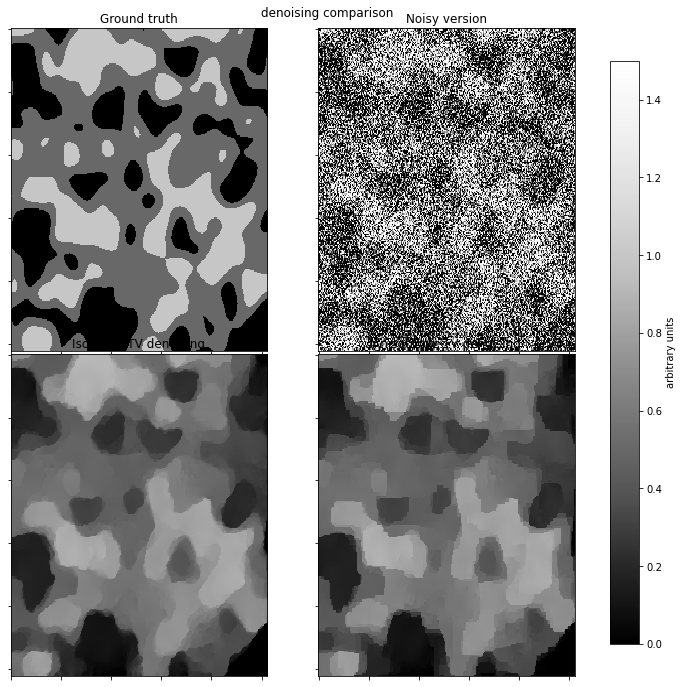

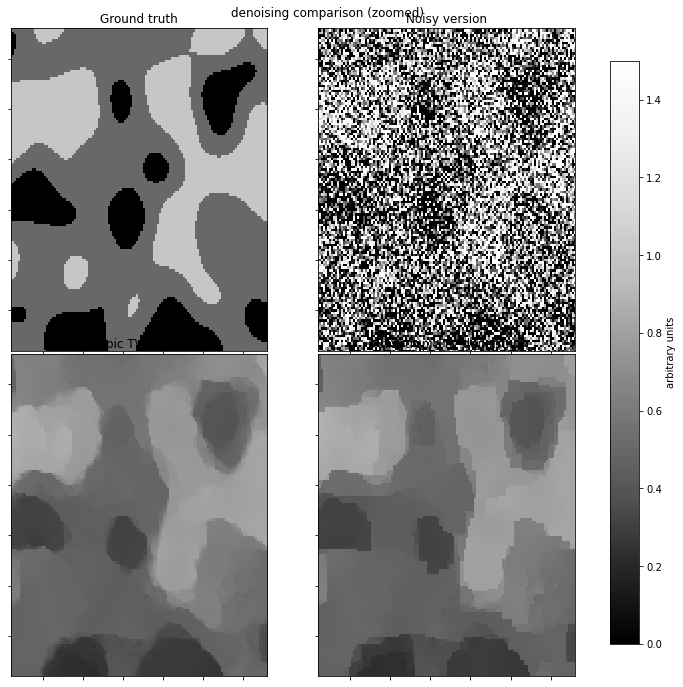

In [12]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.suptitle("denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.suptitle("denoising comparison (zoomed)")
fig.show()